<a href="https://colab.research.google.com/github/d9249/DACON/blob/main/CVLC_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive accept

In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Lib install

In [99]:
!pip install -U statsmodels

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)


# Lib

In [180]:
import time
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from numpy import expand_dims
from sklearn.model_selection import train_test_split, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

## Data Load

In [101]:
train = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/train.csv')
train_digit = train['digit'].values
train_letter = train['letter'].values
train_img = train.iloc[:,3:].values.reshape(-1, 28, 28, 1).astype(np.int)

test  = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/test.csv')
test_img = test.iloc[:,2:].values.reshape(-1, 28, 28, 1).astype(np.int)
X_test_letter = test['letter'].values

submission = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/submission.csv')

train_data = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/test.csv')

In [102]:
print('digit  : ', np.unique(train_digit))
print('letter : ', np.unique(train_letter))

digit  :  [0 1 2 3 4 5 6 7 8 9]
letter :  ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


In [103]:
torch.cuda.is_available()

True

In [104]:
train.set_index('id').head()

,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,1,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,2,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,1,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,4,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,2,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2


In [105]:
test.set_index('id').head()

,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2049,L,0,4,0,2,4,2,3,1,0,0,1,0,1,3,4,4,0,0,2,4,4,1,3,3,2,2,4,1,0,1,2,2,1,2,2,1,4,0,4,...,1,3,1,1,3,3,4,1,3,1,2,4,1,2,0,3,1,2,4,0,2,1,2,4,1,1,3,2,1,0,2,0,4,2,2,4,3,4,1,4
2050,C,4,1,4,0,1,1,0,2,2,1,0,3,0,1,1,4,1,2,0,2,2,0,4,3,4,0,2,4,4,2,1,2,4,0,4,2,0,2,3,...,3,4,2,6,2,2,0,1,2,4,1,1,3,3,2,3,4,2,2,4,3,1,3,3,3,1,3,4,4,2,0,3,2,4,2,4,2,2,1,2
2051,S,0,4,0,1,3,2,3,0,2,1,2,0,1,0,3,0,1,4,3,0,0,3,0,4,1,0,3,2,0,4,1,2,0,0,1,3,0,2,1,...,0,4,4,3,4,1,4,2,3,4,1,2,0,2,2,3,3,1,1,4,1,2,4,0,0,0,0,2,3,2,1,3,2,0,3,2,3,0,1,4
2052,K,2,1,3,3,3,4,3,0,0,2,3,2,3,4,4,4,0,1,4,2,2,0,1,4,3,1,3,0,2,3,2,4,3,1,1,4,0,0,3,...,0,4,1,1,2,3,2,3,3,0,0,1,3,3,0,2,0,0,2,3,2,2,3,1,1,2,4,0,1,2,3,0,3,2,4,1,0,4,4,4
2053,W,1,0,1,1,2,2,1,4,1,1,4,3,4,1,2,1,4,3,3,4,0,4,4,2,0,0,0,0,3,4,0,1,4,2,2,2,1,4,4,...,4,1,3,2,1,2,1,4,4,1,2,3,2,4,2,1,4,3,4,3,0,1,0,1,1,2,1,1,0,2,4,3,1,4,0,2,1,2,3,4


In [106]:
train.shape

(2048, 787)

In [107]:
test.shape

(20480, 786)

# visualize
### 시각화를 통해 추측할 수 있는 내용
- fig
    - left fig : 원본 데이터
    - right fig : 숫자 부분이라 생각되는 부분을 임의로 추출
- letter는 영어 알파벳인데 데이터에는 모두 대문자로 있지만 이미지는 대소문자 구분이 없는 것을 확인 했습니다. 즉, 실제로는 A-Z(26), a-z(26) 으로 52개가 있는 것으로 보입니다.
- 이미지를 봤을 때 데이터가 만들어진 과정을 추측해보면 letter가 먼저 그려지고 digit을 그리는데 이 때 digit은 letter와 겹치는 부분만 남기고 나머지 부분은 제거하는 방식 인 것 같습니다. -> 단지 제 생각입니다...!
- 겹쳐져 있는 부분의 pixel 값은 약간 다른 것을 확인할 수 있었습니다.
- 임의로 일정 pixel 이상의 값을 가진 것만 남겨 이미지를 출력해보면 어떤 형태로 데이터가 생성 됐을지 예상할 수 있습니다.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


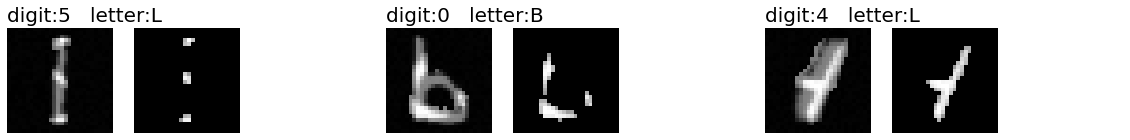

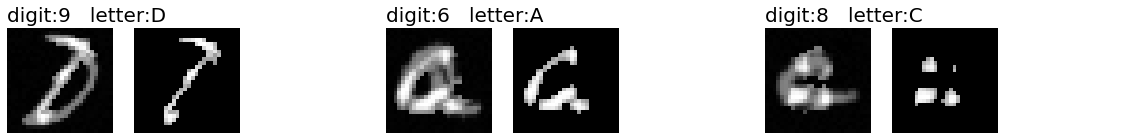

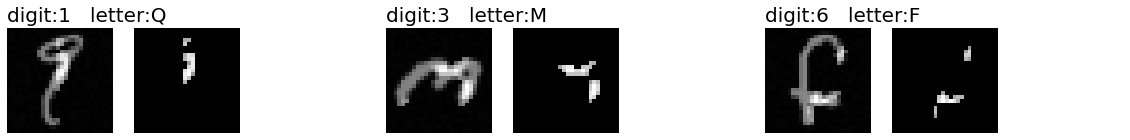

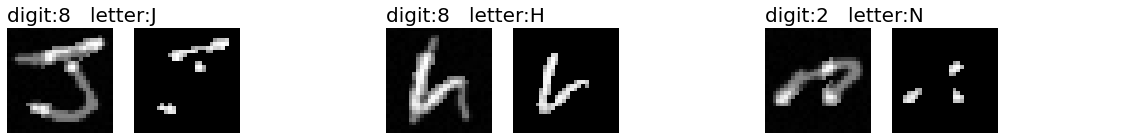

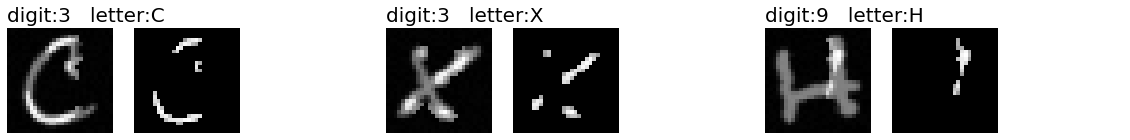

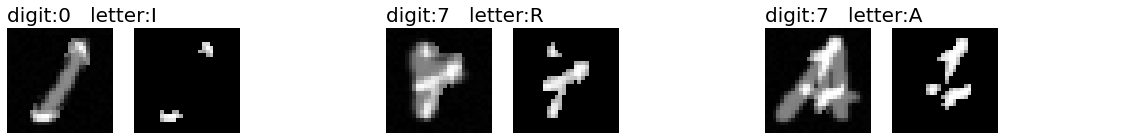

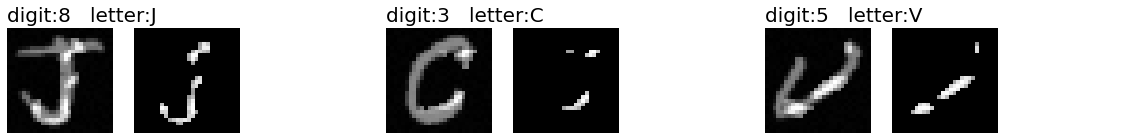

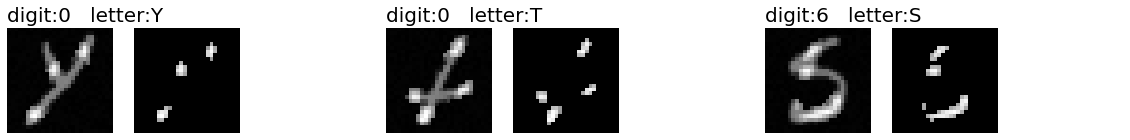

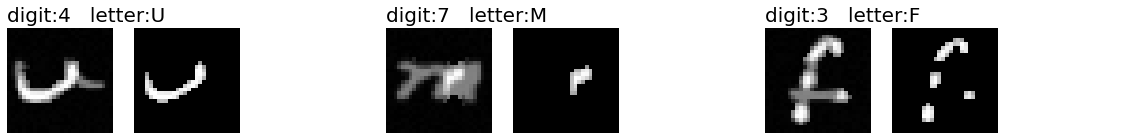

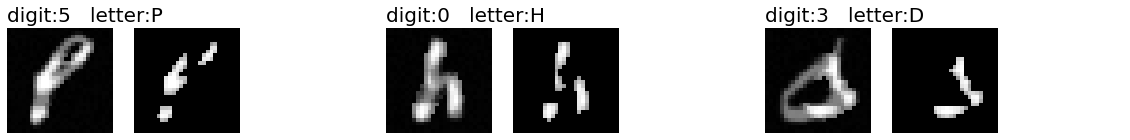

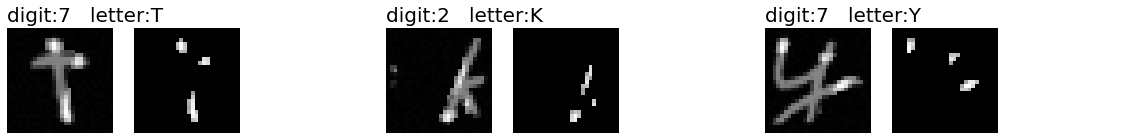

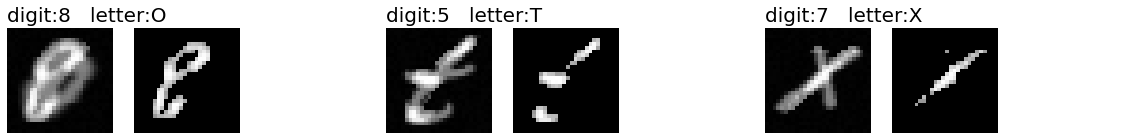

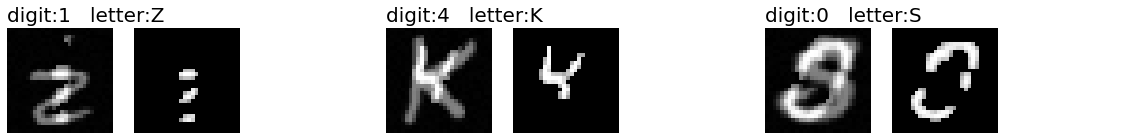

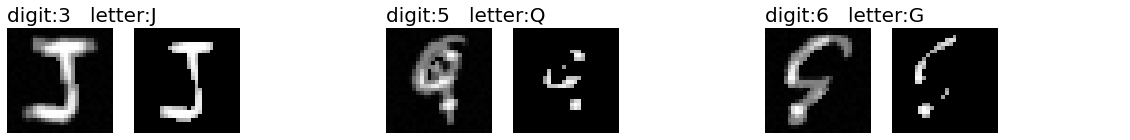

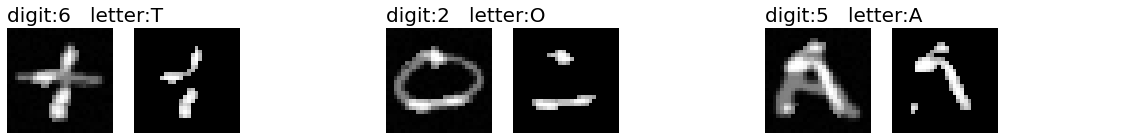

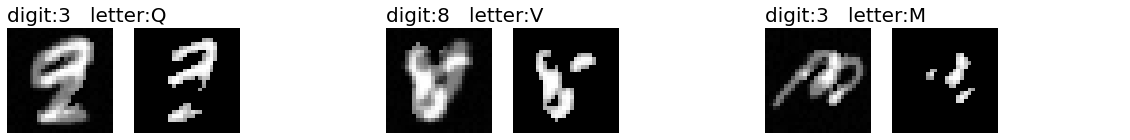

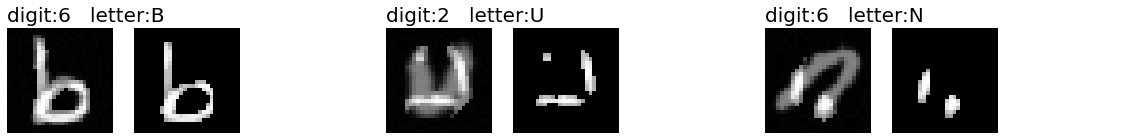

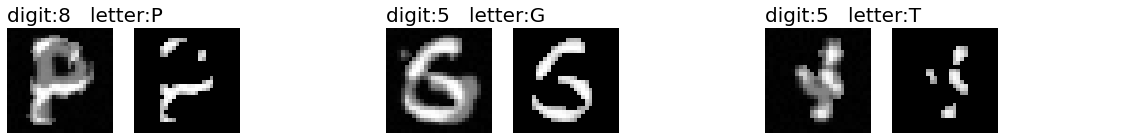

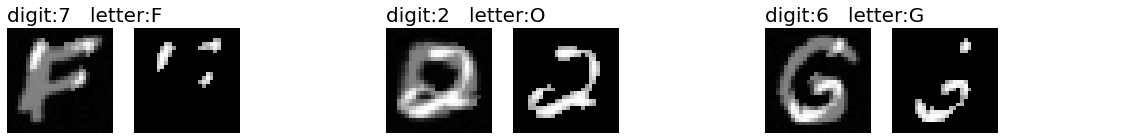

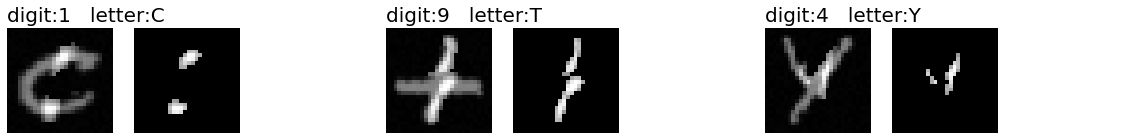

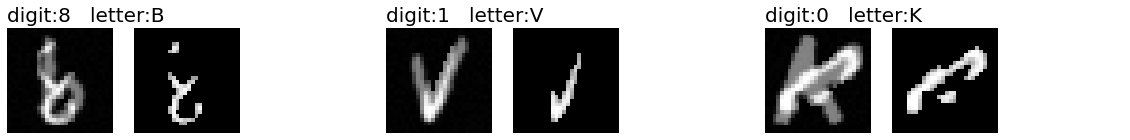

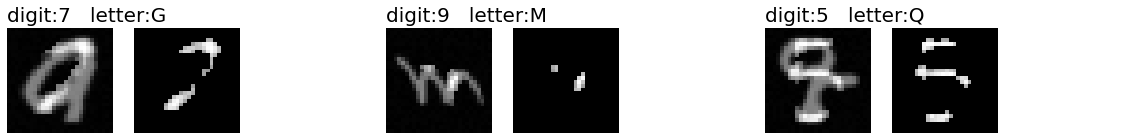

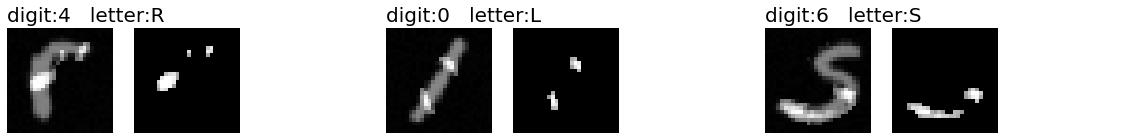

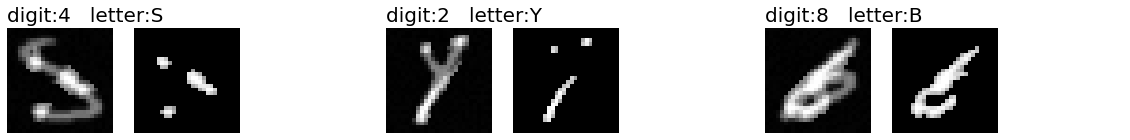

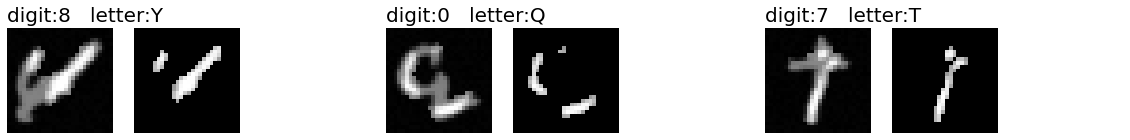

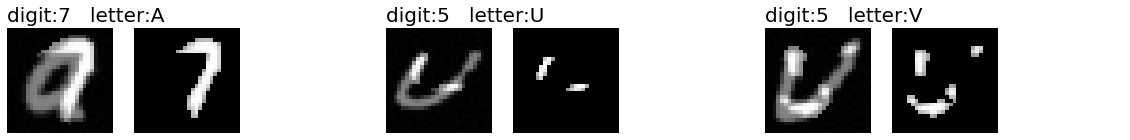

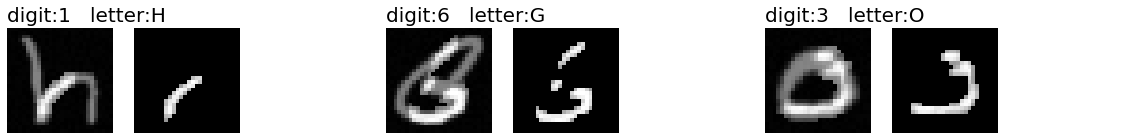

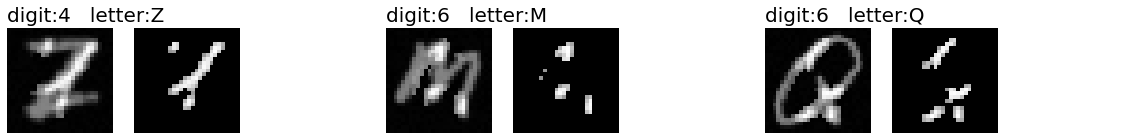

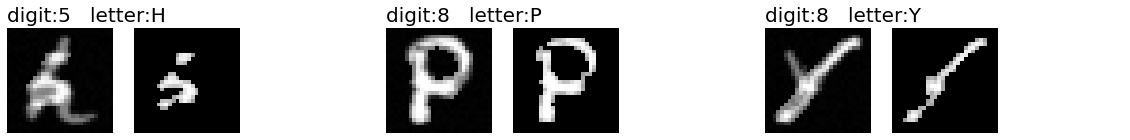

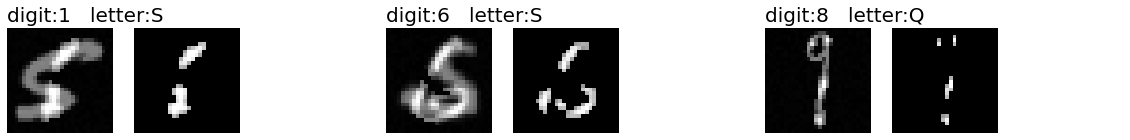

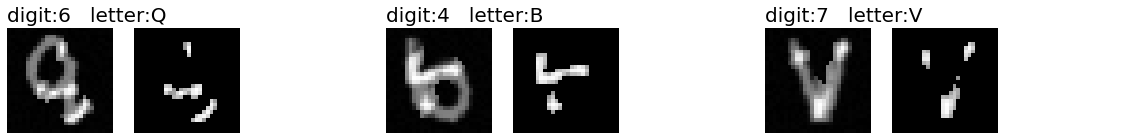

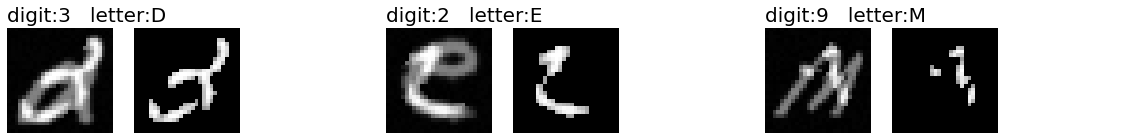

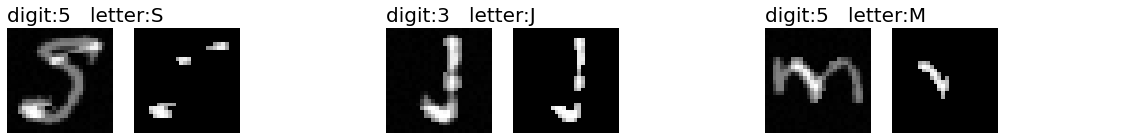

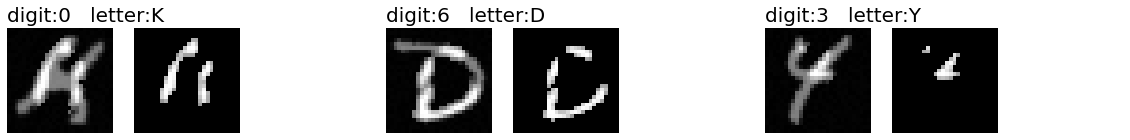

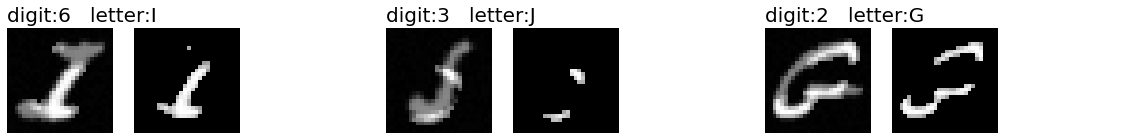

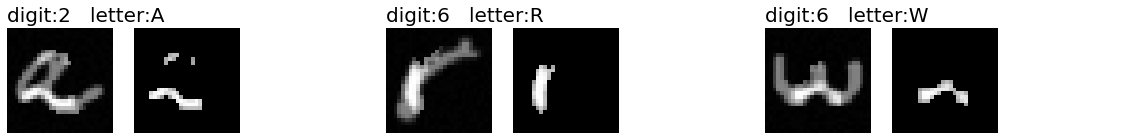

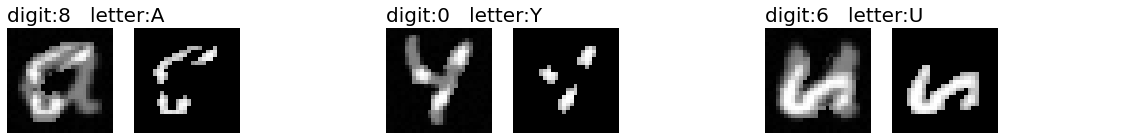

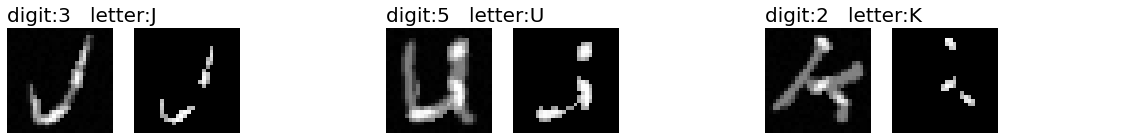

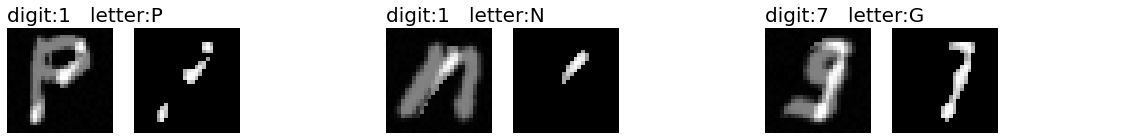

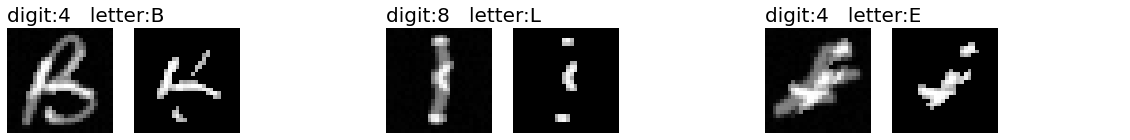

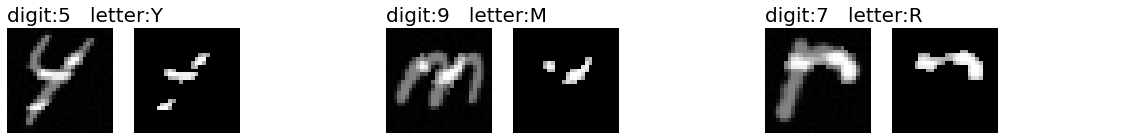

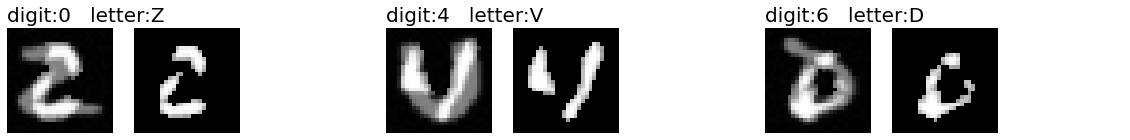

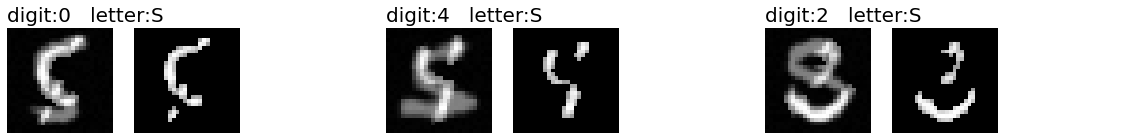

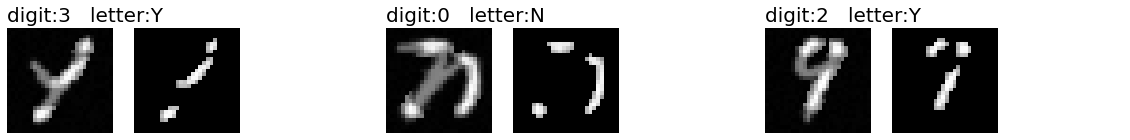

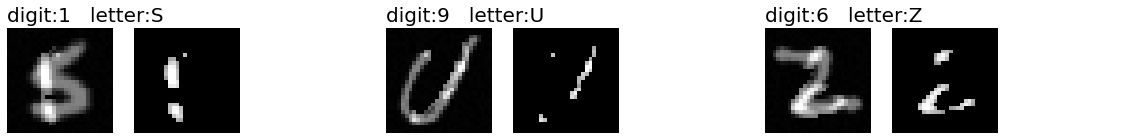

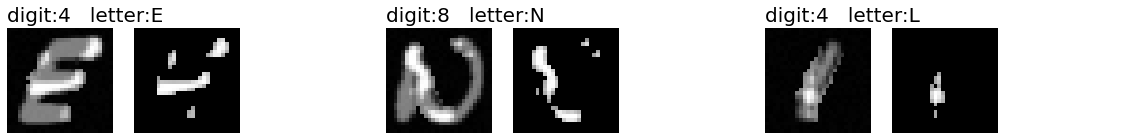

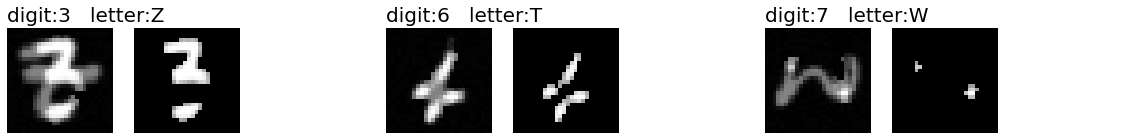

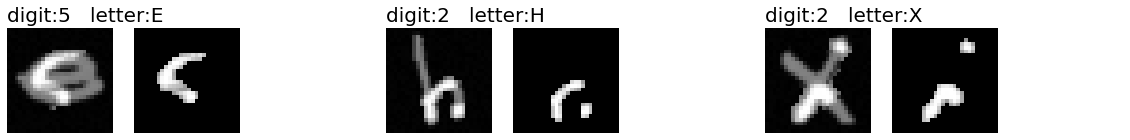

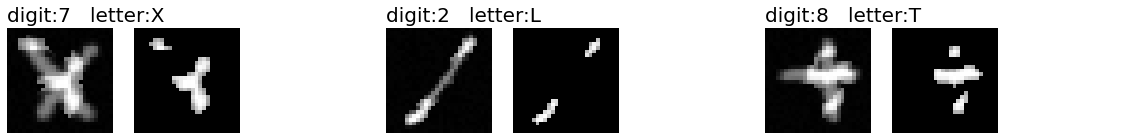

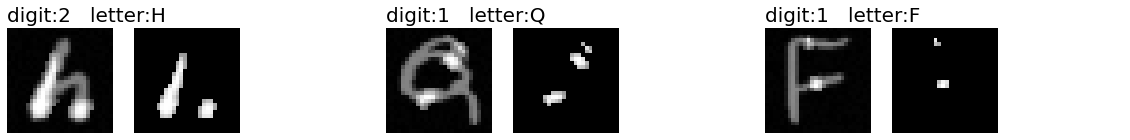

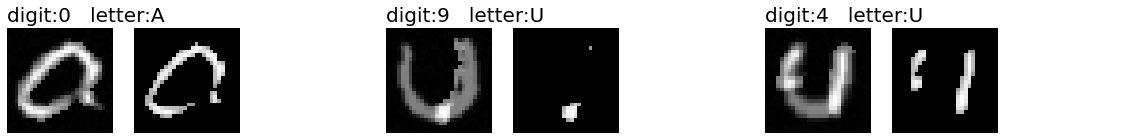

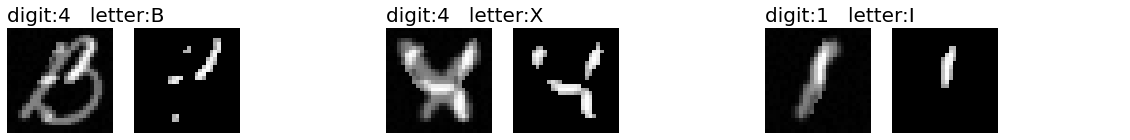

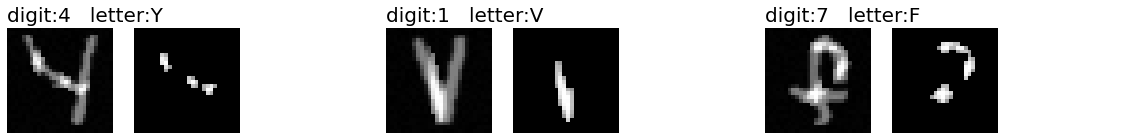

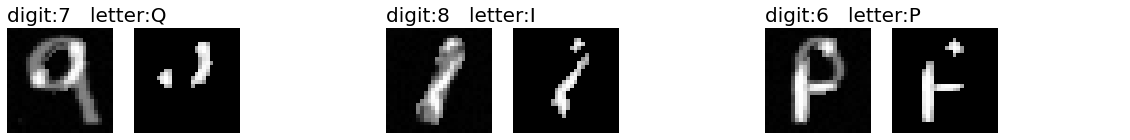

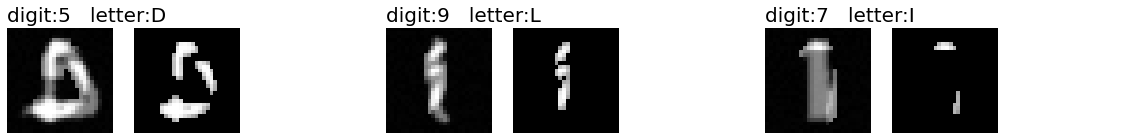

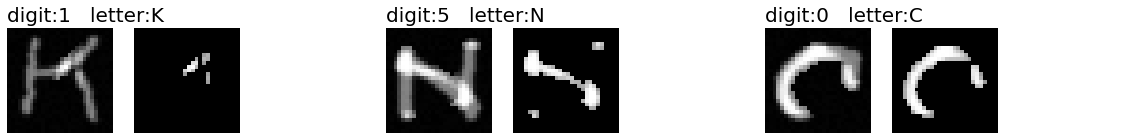

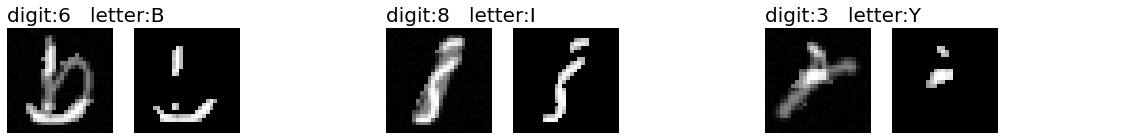

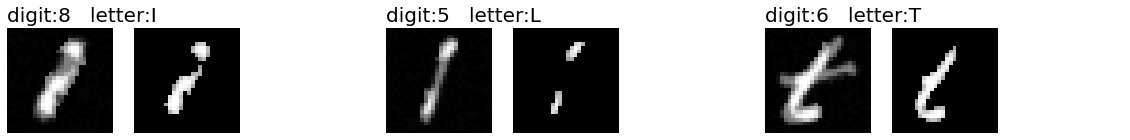

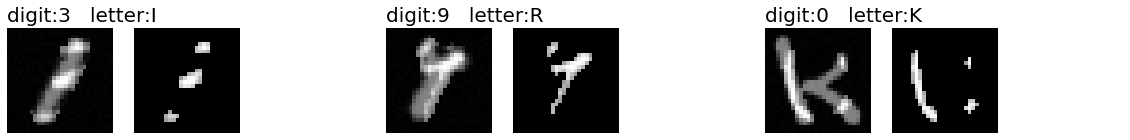

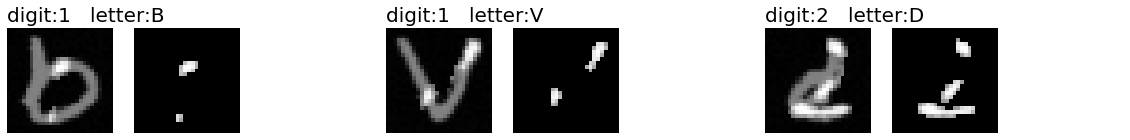

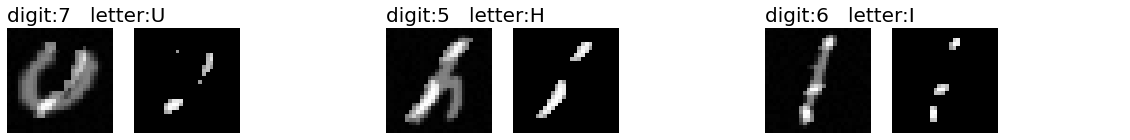

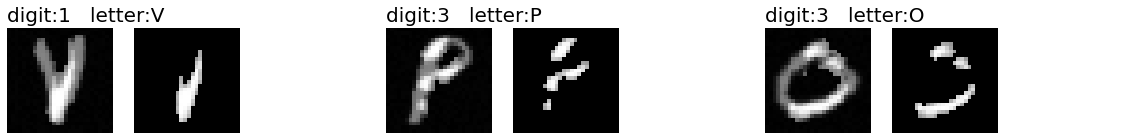

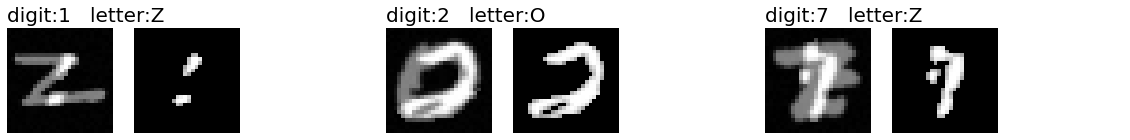

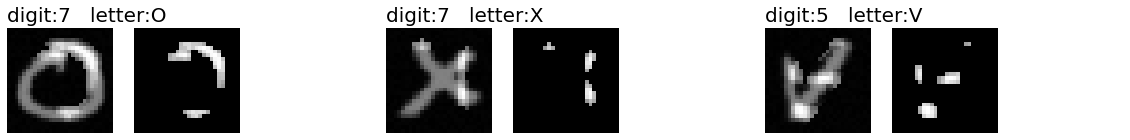

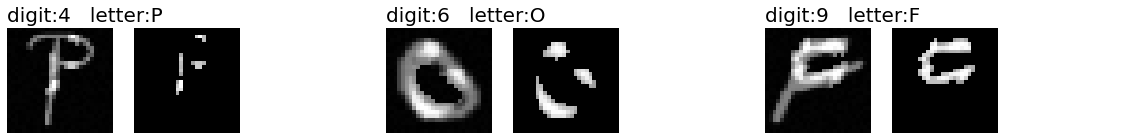

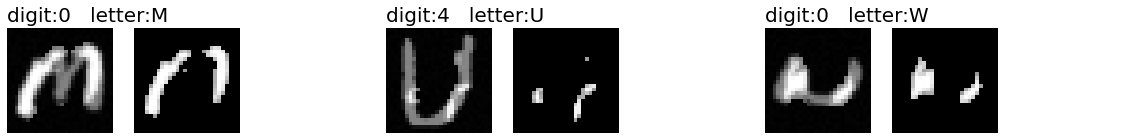

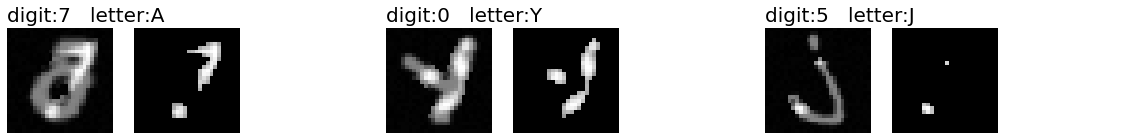

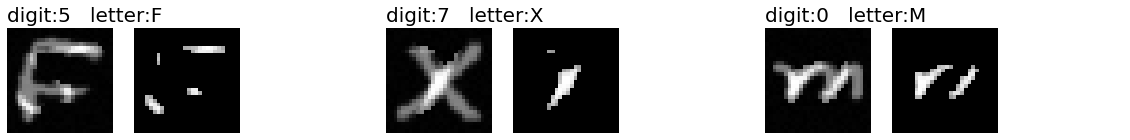

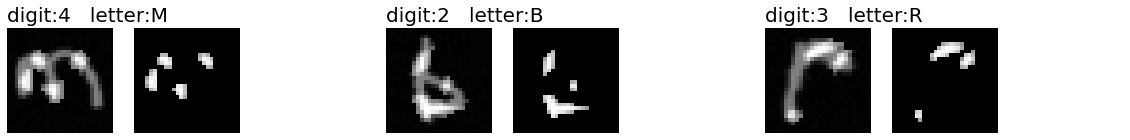

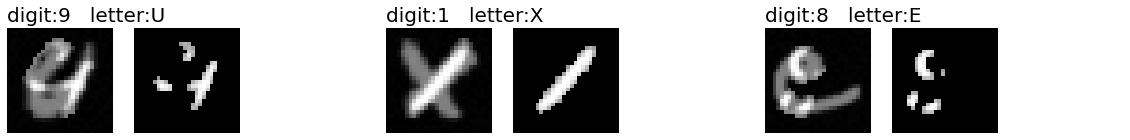

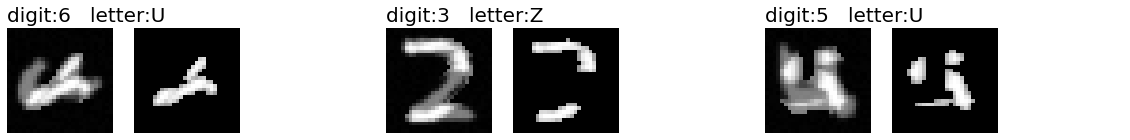

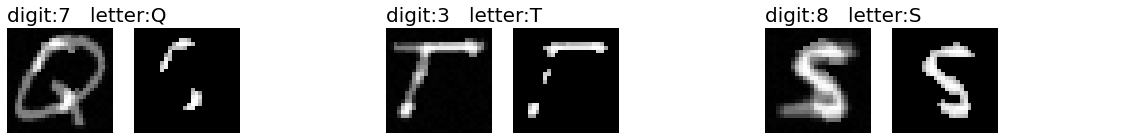

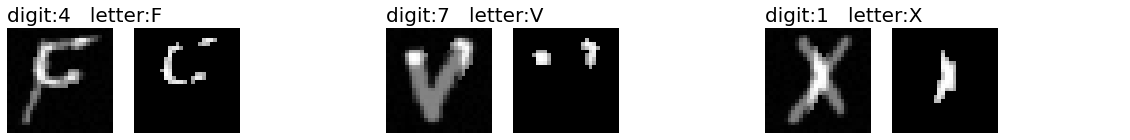

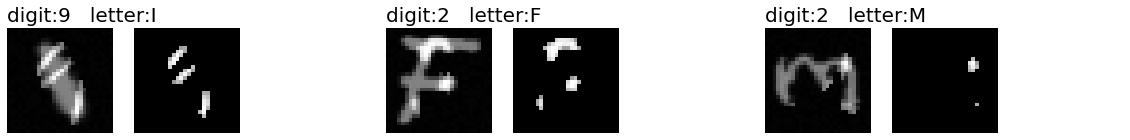

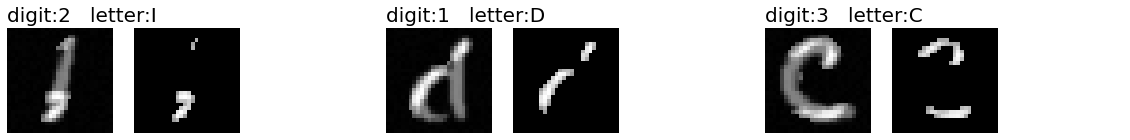

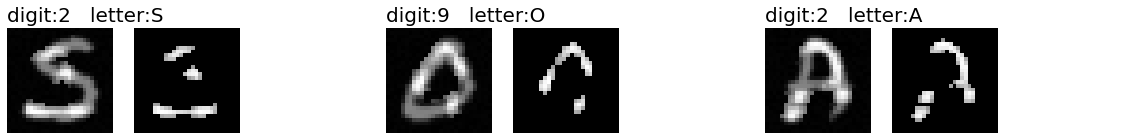

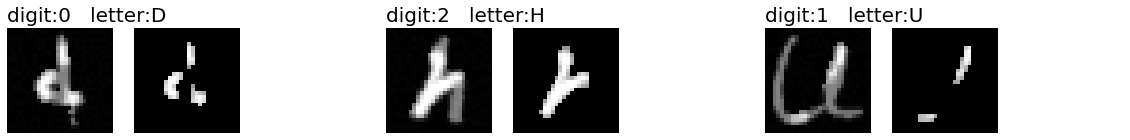

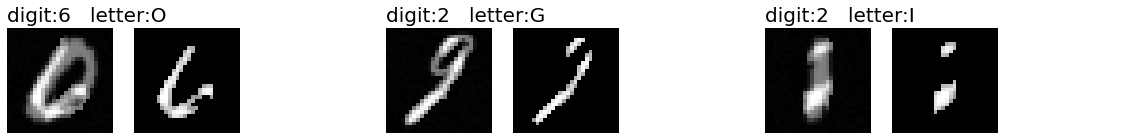

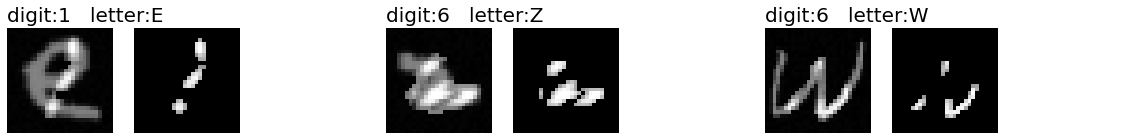

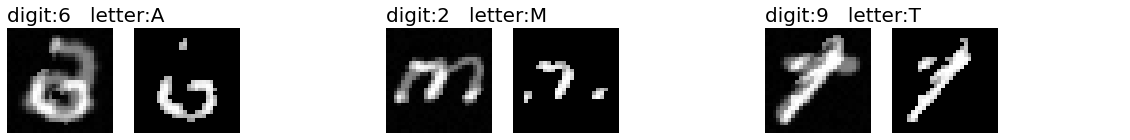

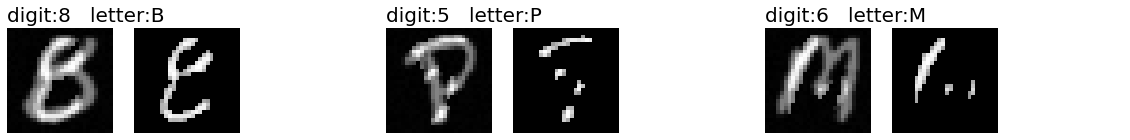

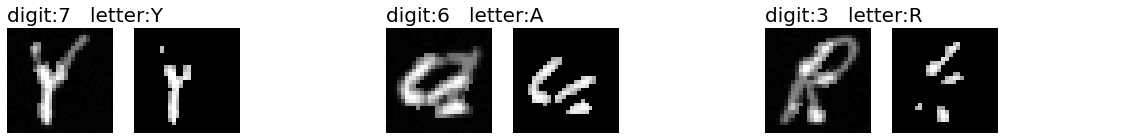

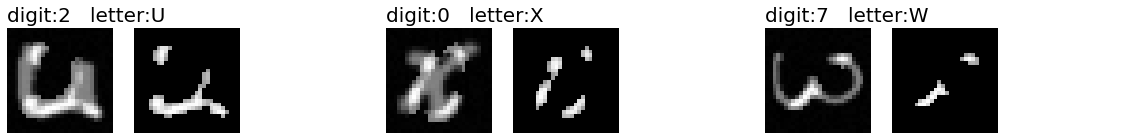

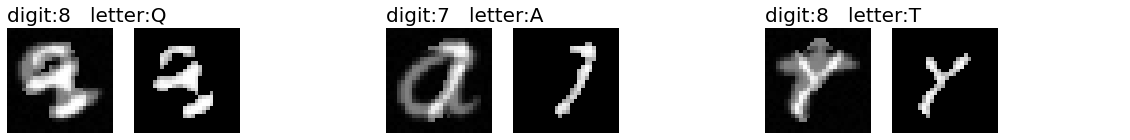

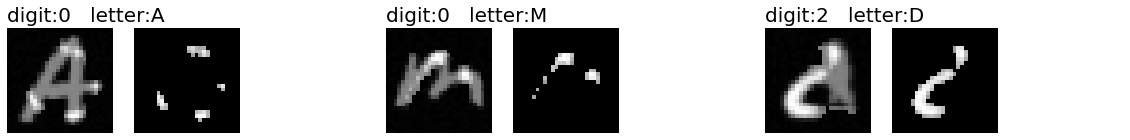

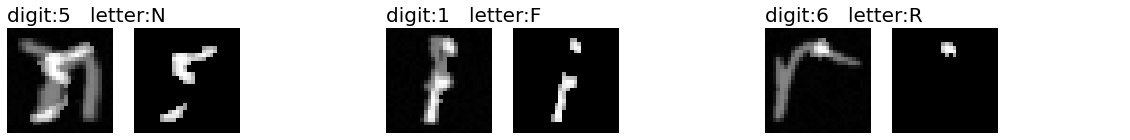

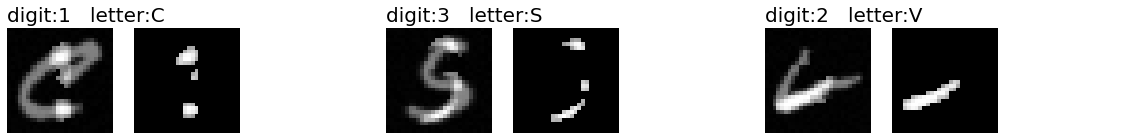

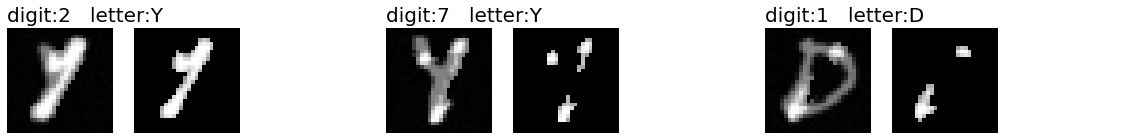

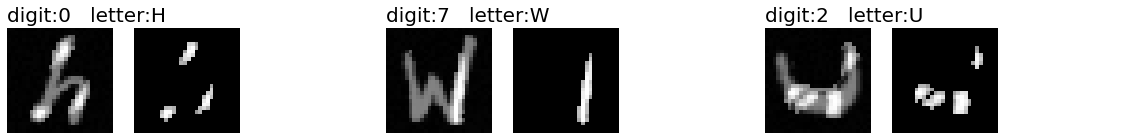

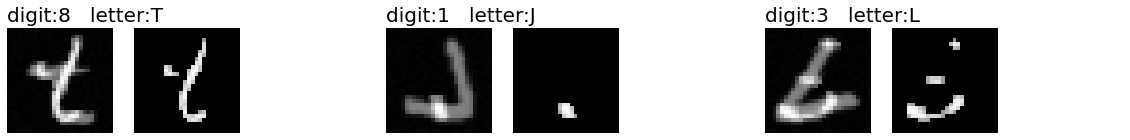

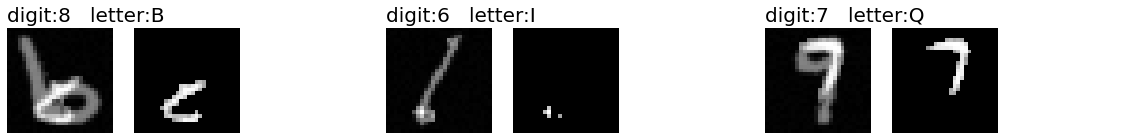

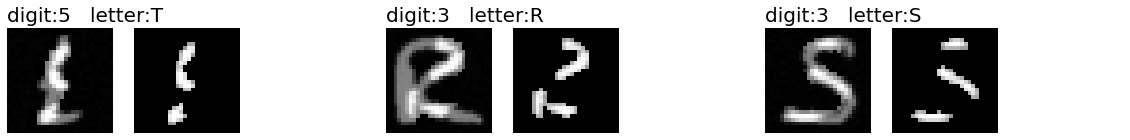

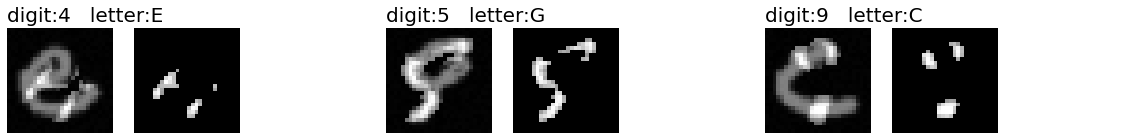

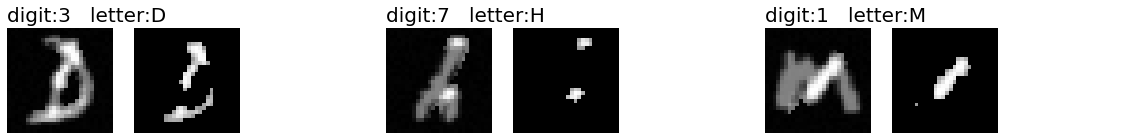

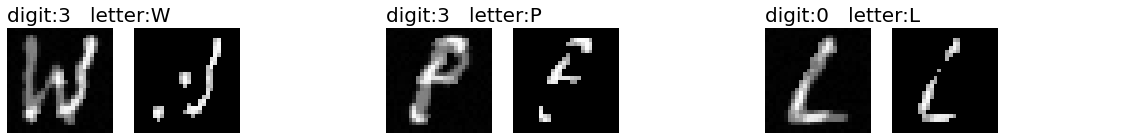

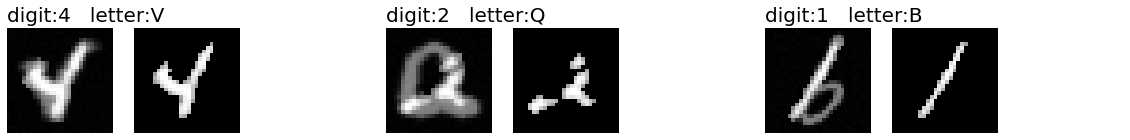

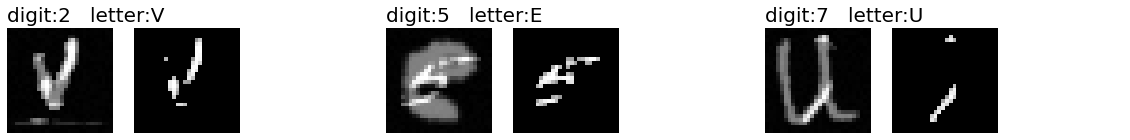

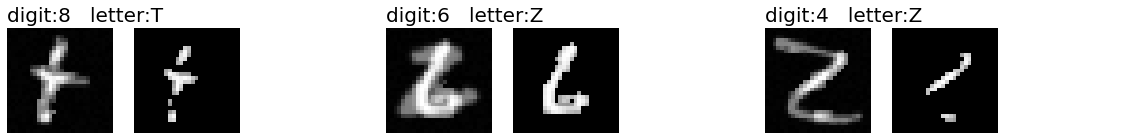

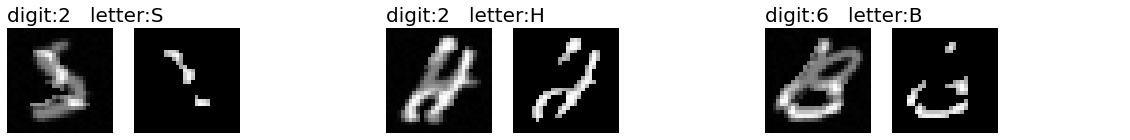

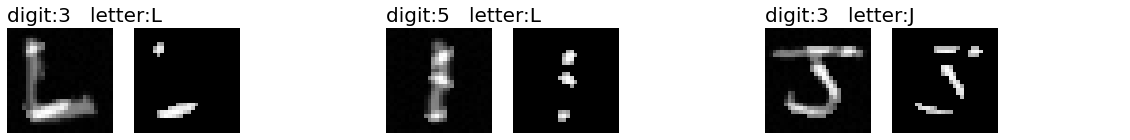

In [108]:
for idx in range(0, 300, 3):
    plt.figure(figsize=(20,30))
    plt.subplot(1,9,1)
    plt.imshow(train_img[idx].reshape(28,28),cmap='gray')
    plt.axis('off')
    
    plt.title('digit:{}   letter:{}'.format(train_digit[idx], train_letter[idx]), loc='left', fontsize=20)

    plt.subplot(1,9,2)
    data = np.where(train_img>=150, train_img, 0)
    plt.imshow(data[idx].reshape(28,28),cmap='gray')
    plt.axis('off')

    plt.subplot(1,9,3)
    plt.imshow(np.zeros((28,28,3))+1,cmap='gray')
    plt.axis('off')
    
    
    plt.subplot(1,9,4)
    plt.imshow(train_img[idx+1].reshape(28,28),cmap='gray')
    plt.axis('off')
    
    plt.title('digit:{}   letter:{}'.format(train_digit[idx+1], train_letter[idx+1]), loc='left', fontsize=20)

    plt.subplot(1,9,5)
    data = np.where(train_img>=150, train_img, 0)
    plt.imshow(data[idx+1].reshape(28,28),cmap='gray')
    plt.axis('off')

    plt.subplot(1,9,6)
    plt.imshow(np.zeros((28,28,3))+1,cmap='gray')
    plt.axis('off')
    
    
    plt.subplot(1,9,7)
    plt.imshow(train_img[idx+2].reshape(28,28),cmap='gray')
    plt.axis('off')
    
    plt.title('digit:{}   letter:{}'.format(train_digit[idx+2], train_letter[idx+2]), loc='left', fontsize=20)

    plt.subplot(1,9,8)
    data = np.where(train_img>=150, train_img, 0)
    plt.imshow(data[idx+2].reshape(28,28),cmap='gray')
    plt.axis('off')

    plt.subplot(1,9,9)
    plt.imshow(np.zeros((28,28,3))+1,cmap='gray')
    plt.axis('off')
    
plt.show()

- letter 정보를 어떻게 활용할 수 있을지. -> letter의 값을 one-hot-vector로 만든 후 layer의 입력으로 활용해 보는 것도 ? ..
- 적은 데이터를 통해 어떤 방식을 활용하면 효율적인 학습을 할 수 있을지.
- public LB는 20480개중 1%의 데이터로 약 205개 정도로만 측정이되니 나중에 전체 데이터로 측정 될 때는 또 다르게 나올 수 있을 것 같습니다.

# Dataset의 분포 

In [109]:
train_df_letter = train['letter'].values

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


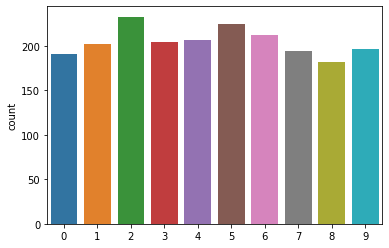

In [110]:
sns.countplot(train.digit.values)

# 숫자별 알파벳 빈도

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

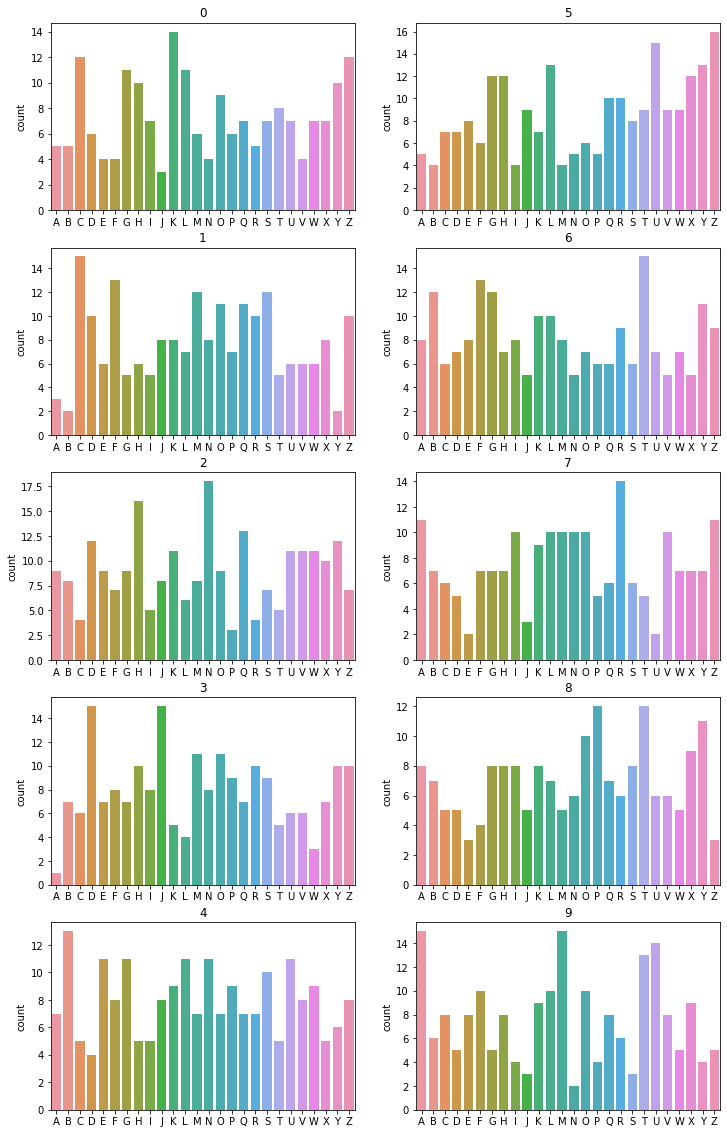

In [111]:
fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(12,20))

col = 0
row = 0

for target_number in range(10): 
    if row == 5 and col==0:
        col+=1
        row = 0
    
    sns.countplot(sorted(train.loc[train.digit==target_number,'letter'].values), ax=axes[row,col]).set_title(str(target_number))
    row+=1

# 알파벳별 숫자 빈도

In [112]:
letter_unique = train['letter'].values
unique_letter = set(letter_unique)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

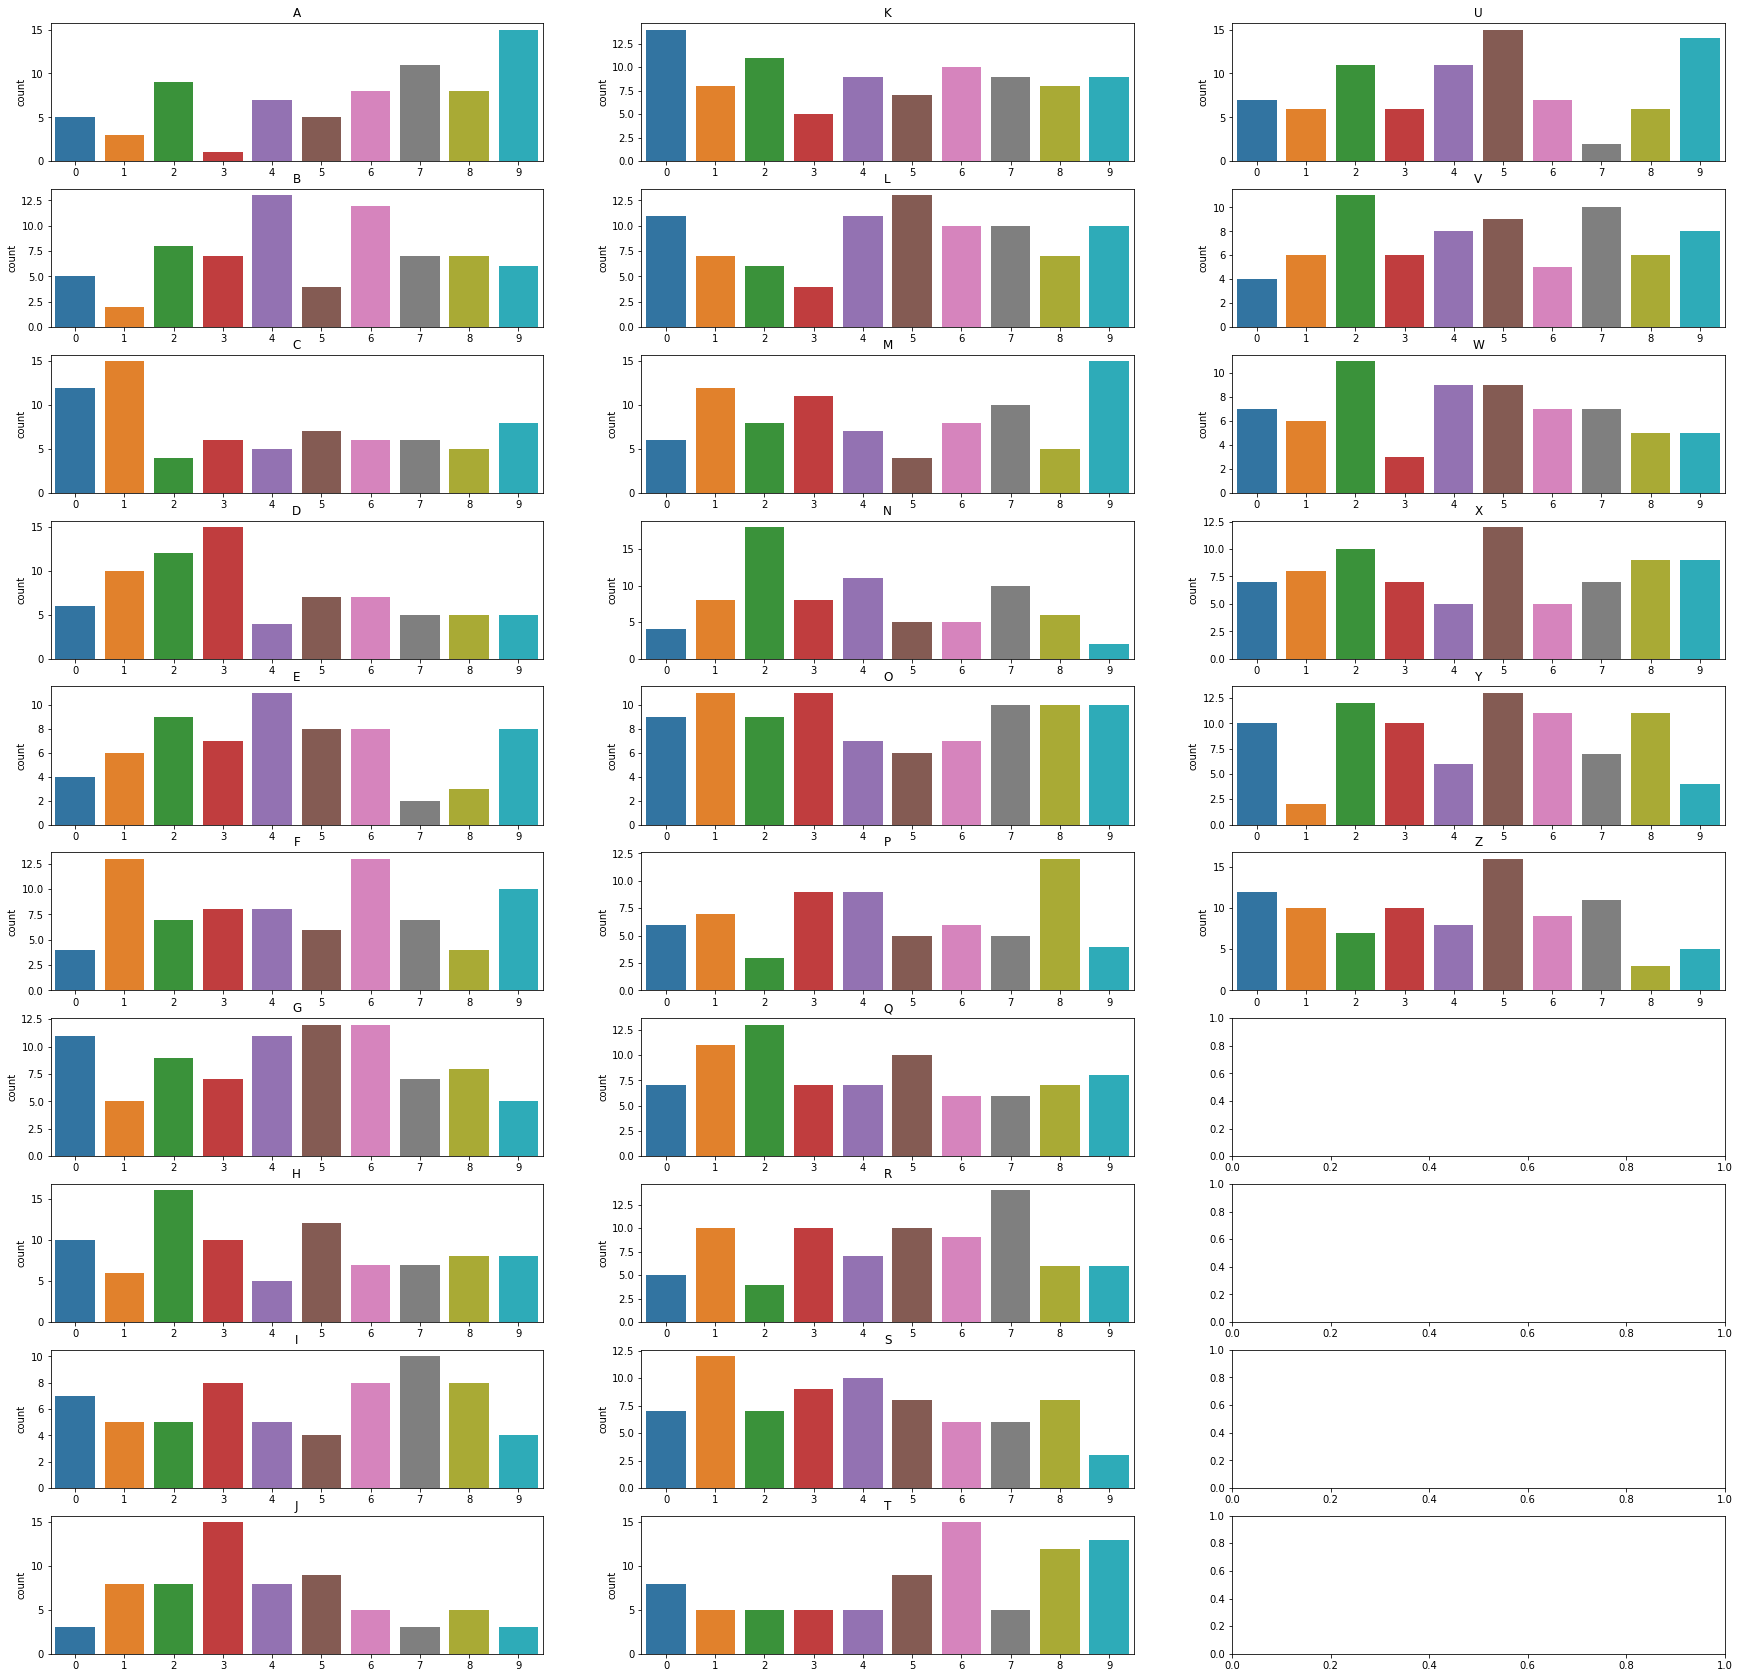

In [113]:
fig, axes = plt.subplots(nrows=10, ncols=3,figsize=(30,30))

col = 0
row = 0

for target_letter in sorted(list(unique_letter)): 
    if row == 10: #and col==0:
        col+=1
        row = 0
    
    sns.countplot(train.loc[train.letter==target_letter,'digit'].values, ax=axes[row,col]).set_title(str(target_letter))
    row+=1

# Train 이미지 분석

In [114]:
def show_10_imgs(imgs):
    plt.figure(figsize=(20, 5))
    for i in range(10):
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [115]:
def save_10_imgs(imgs):
    plt.figure(figsize=(20, 5))
    for i in range(10):
        plt.imshow(imgs[i])
        plt.savefig(f"{i}.png")

    plt.show()

In [116]:
def imgs_save(imgs):
    plt.figure(figsize=(20, 5))
    for i in range(10):
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.savefig(i+'.png', imgs[i])

In [117]:
X_train = np.array(train_data.drop(['id', 'digit', 'letter'], axis=1)).astype('float32')
X_test = np.array(test_data.drop(['id', 'letter'], axis=1)).astype('float32')

y_train = to_categorical(np.array(train_data['digit']), num_classes=10)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1004)

X_train = X_train.reshape((X_train.shape[0], 28, 28))
X_val = X_val.reshape((X_val.shape[0], 28, 28))
X_test = X_test.reshape((X_test.shape[0], 28, 28))

## 원본 숫자 이미지

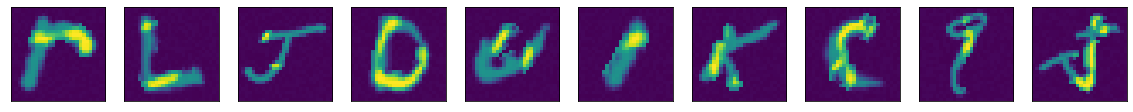

In [118]:
show_10_imgs(X_train)

In [119]:
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

threshold = 0.6
X_train[X_train > threshold] = 0
X_val[X_val > threshold] = 0
X_test[X_test > threshold] = 0

## 숫자가 있어서는 안되는 영역

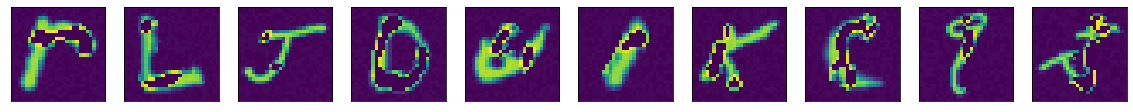

In [120]:
show_10_imgs(X_train)

In [121]:
X_train = np.array(train_data.drop(['id', 'digit', 'letter'], axis=1)).astype('float32')
X_test = np.array(test_data.drop(['id', 'letter'], axis=1)).astype('float32')

y_train = to_categorical(np.array(train_data['digit']), num_classes=10)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1004)

X_train = X_train.reshape((X_train.shape[0], 28, 28))
X_val = X_val.reshape((X_val.shape[0], 28, 28))
X_test = X_test.reshape((X_test.shape[0], 28, 28))

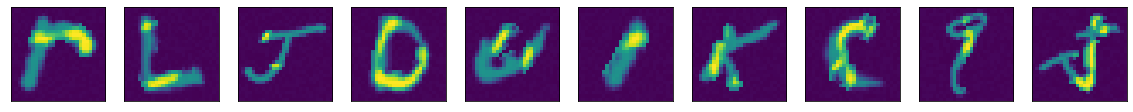

In [122]:
show_10_imgs(X_train)

In [123]:
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

threshold = 0.6
X_train[X_train < threshold] = 0
X_val[X_val < threshold] = 0
X_test[X_test < threshold] = 0

## 숫자가 무조건 있는 영역

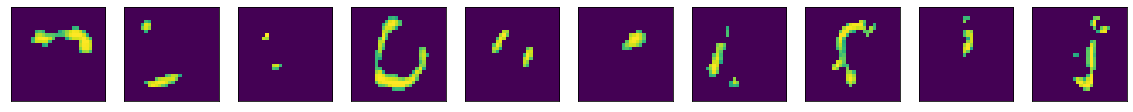

In [124]:
show_10_imgs(X_train)

In [125]:
digit_ref = np.zeros((10, 28, 28))
for (idx, digit) in enumerate(y_train):
    digit = np.argmax(digit)
    digit_ref[digit] += X_train[idx]

digit_ref = digit_ref / np.max(digit_ref)

## 전체  Train Data에서 보이는 숫자 부분의 모든 이미지를 겹친 이미지 
( 0~9의 숫자를 가장 잘 나타내는 영역의 시각화 )  

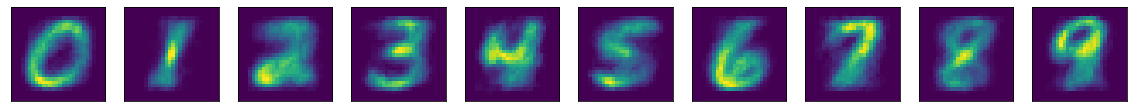

In [126]:
show_10_imgs(digit_ref)

In [127]:
digit_ref[digit_ref < 0.1] = 0

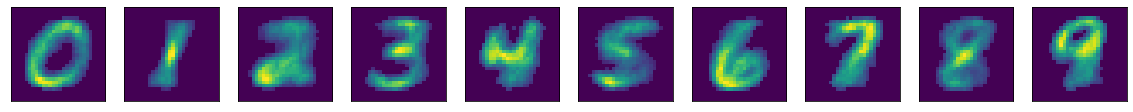

In [128]:
show_10_imgs(digit_ref)

In [129]:
digit_ref[digit_ref < 0.2] = 0

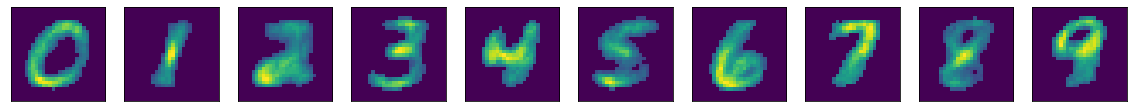

In [130]:
show_10_imgs(digit_ref)

In [131]:
digit_ref[digit_ref < 0.2] = 0

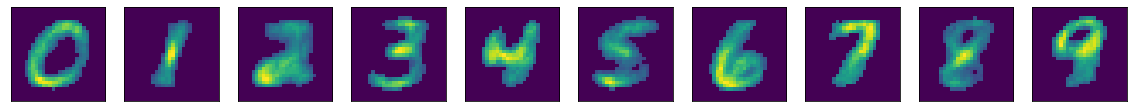

In [132]:
show_10_imgs(digit_ref)

In [133]:
digit_ref[digit_ref < 0.3] = 0

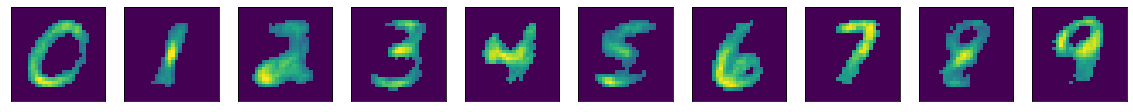

In [134]:
show_10_imgs(digit_ref)

In [135]:
digit_ref[digit_ref < 0.4] = 0

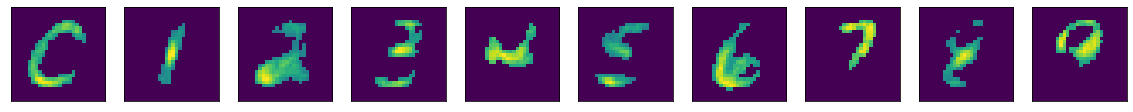

In [136]:
show_10_imgs(digit_ref)

In [137]:
digit_ref[digit_ref < 0.5] = 0

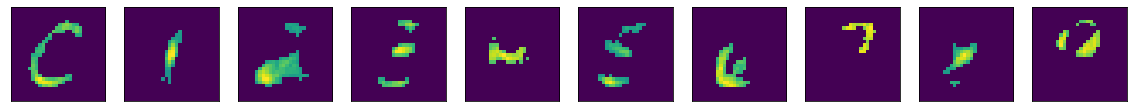

In [138]:
show_10_imgs(digit_ref)

In [139]:
digit_ref[digit_ref < 0.6] = 0

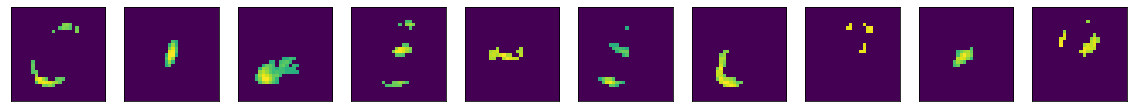

In [140]:
show_10_imgs(digit_ref)

## 위의 예시 중 0~9의 숫자를 가장 잘 나타내는 이미지 

In [141]:
digit_ref = np.zeros((10, 28, 28))
for (idx, digit) in enumerate(y_train):
    digit = np.argmax(digit)
    digit_ref[digit] += X_train[idx]

digit_ref = digit_ref / np.max(digit_ref)

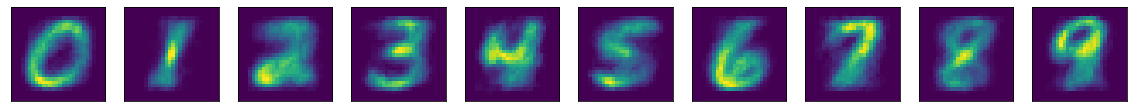

In [142]:
show_10_imgs(digit_ref)

In [143]:
digit_ref[digit_ref < 0.25] = 0

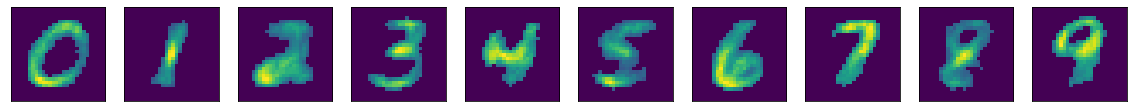

In [144]:
show_10_imgs(digit_ref)

In [145]:
digit_ref[digit_ref != 0] = 1

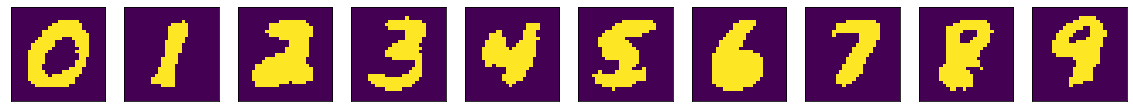

In [146]:
show_10_imgs(digit_ref)

# IDEA

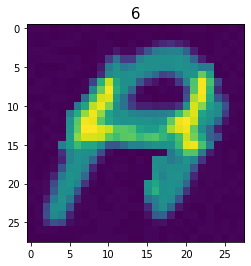

In [147]:
i = 0
img = train.query("letter == 'A'")[
        [(str(i)) for i in range(784)]
    ].iloc[28].values.reshape(28, 28)
plt.imshow(img)
plt.title(train.query("letter == 'A'").iloc[i]['digit'], fontsize=15)
plt.show()

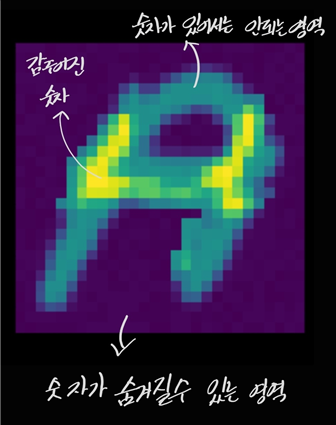

IDEA
 - 무조건 적으로 숫자가 보이는 부분과 숫자가 존재해서는 안되는 영역이 명확하게 존재하므로 이를 이용하여 학습을 진행한다면, 높은 정확도를 보일 수 있을 것 같다.

1. 3개의 라벨을 구분 후 함께 같이 학습 시킨다.
    1. train_a = 감추어진 숫자가 있는 이미지
    2. train_b = 숫자가 숨겨질 수 있는 부분의 이미지
    3. train_c = 숫자가 있어서는 안되는 부분의 이미지

학습에 사용될 데이터 
 - letter 숫자를 가리는 알파벳에 대한 정보
 - 숨겨진 숫자의 대한 정보 
 - 그리고 위에 3개에 대한 정보

Task
 - 여러 개의 라벨을 가진 이미지에 대한 학습의 성능이 좋은 모델을 알아봐야한다.
 - Train Data set이 부족하기 때문에 이를 보완할 방법을 찾아야한다.

In [148]:
train.query("letter == 'A'").iloc[28].iloc[:3]

id        774
digit       4
letter      A
Name: 773, dtype: object

In [149]:
from scipy.signal import correlate2d

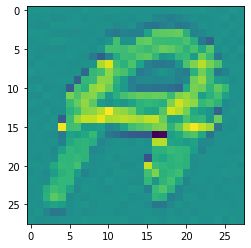

In [150]:
# 이런 식으로 특성을 파악하는 것이 목적이다.

kernel = np.array(
    [
        [0, -100, 0],
        [0, 255, 0],
        [0, -100, 0],
    ]
)
plt.imshow(correlate2d(img, kernel, mode='same'))

In [151]:
# 문자는 one-hot encoding한 후에 (-1, 1, 26)으로 reshape
# pixel값들도 (-1, 1, 784)로 reshape
# 그 후 concat하여 (2048, 1, 810)으로 X_train 구축
X_train = np.concatenate(
    [
        pd.get_dummies(train.letter).values.reshape(-1, 1, 26),
        (train[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ], 
    axis=2
)
# Label Setting
y_train = train['digit'].values

# Train-Test를 8:2로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [152]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1638, 1, 810), (410, 1, 810), (1638,), (410,))

# Data argmentation

In [169]:
train2 = train.drop(['id', 'digit', 'letter'], axis=1)
test2 = test.drop(['id', 'letter'], axis=1)

In [170]:
train2 = train2.values
test2 = test2.values

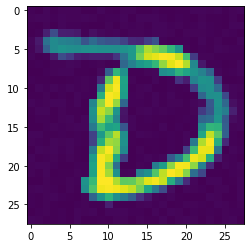

In [171]:
plt.imshow(train2[100].reshape(28, 28))

In [172]:
train2 = train2.reshape(-1, 28, 28, 1)
test2 = test2.reshape(-1, 28, 28, 1)

In [173]:
train2 = train2 / 255.0
test2 = test2 / 255.0

In [174]:
idg = ImageDataGenerator(height_shift_range=(-1,1), width_shift_range=(-1,1))
idg2 = ImageDataGenerator()

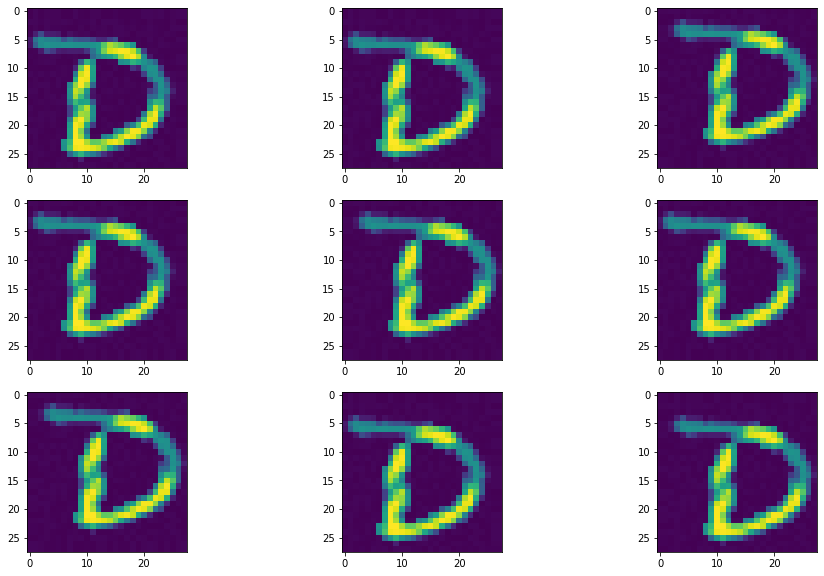

In [177]:
sample_data = train2[100].copy()
sample_data.shape
sample = expand_dims(sample_data, 0)
sample_datagen = ImageDataGenerator(height_shift_range=(-1,1), width_shift_range=(-1,1))
sample_generator = sample_datagen.flow(sample, batch_size=1)

plt.figure(figsize=(16,10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    sample_batch = sample_generator.next()
    sample_image = sample_batch[0]
    plt.imshow(sample_image.reshape(28,28))

# Train (tensorflow)

In [182]:
skf = StratifiedKFold(n_splits=40, random_state=42, shuffle=True)

In [183]:
# Collback = Local Minima에 빠져버린 경우, 쉽게 빠져나오지 못하고 갇혀버리게 되는데, 이때 learning rate를 늘리거나 줄여주는 방법으로 빠져나오는 효과를 기대할 수 있습니다.
reLR = ReduceLROnPlateau(patience=100,verbose=1,factor=0.5) #learning rate scheduler

# patience = 성능이 증가하지 않는 epoch 을 몇 번이나 허용할 것인가
# verbose = training 을 멈추었는지를 화면에 출력할 수 있다. 
es = EarlyStopping(patience=160, verbose=1)

val_loss_min = []
result = 0
nth = 0

for train_index, valid_index in skf.split(train2,train['digit']) :
    
    # 이 객체는 validation error 를 모니터링하면서, 이전 epoch 에 비해 validation performance 가 좋은 경우, 무조건 이 때의 parameter 들을 저장한다. 
    # 이를 통해 트레이닝이 중지되었을 때, 가장 validation performance 가 높았던 모델을 반환할 수 있다. 
    mc = ModelCheckpoint('best_cvision.h5',save_best_only=True, verbose=1)
    
    x_train = train2[train_index]
    x_valid = train2[valid_index]    
    y_train = train['digit'][train_index]
    y_valid = train['digit'][valid_index]
    
    train_generator = idg.flow(x_train,y_train,batch_size=8)
    valid_generator = idg2.flow(x_valid,y_valid)
    test_generator = idg2.flow(test2,shuffle=False)
    
    model = Sequential()
    
    model.add(Conv2D(16,(3,3),activation='relu',input_shape=(28,28,1),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(5,5),activation='relu',padding='same')) 
    model.add(BatchNormalization())
    model.add(Conv2D(32,(5,5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(5,5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3,3)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(5,5),activation='relu',padding='same')) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3,3)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())

    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(10,activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.002,epsilon=None),metrics=['acc'])
    
    learning_history = model.fit_generator(train_generator,epochs=2000, validation_data=valid_generator, callbacks=[es,mc,reLR])
    
    # predict
    model.load_weights('best_cvision.h5')
    result += model.predict_generator(test_generator,verbose=True)/40
    
    # save val_loss
    hist = pd.DataFrame(learning_history.history)
    val_loss_min.append(hist['val_loss'].min())
    
    nth += 1
    print(nth, '번째 학습을 완료했습니다.')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2000
250/250 [==============================] - 18s 8ms/step - loss: 2.5890 - acc: 0.1723 - val_loss: 4.9217 - val_acc: 0.0962

Epoch 00001: val_loss improved from inf to 4.92172, saving model to best_cvision.h5
Epoch 2/2000
250/250 [==============================] - 2s 7ms/step - loss: 2.0892 - acc: 0.2550 - val_loss: 4.9623 - val_acc: 0.1538

Epoch 00002: val_loss did not improve from 4.92172
Epoch 3/2000
250/250 [==============================] - 2s 7ms/step - loss: 1.7546 - acc: 0.3778 - val_loss: 2.2957 - val_acc: 0.2692

Epoch 00003: val_loss improved from 4.92172 to 2.29568, saving model to best_cvision.h5
Epoch 4/2000
250/250 [==============================] - 2s 7ms/step - loss: 1.4436 - acc: 0.5070 - val_loss: 1.4028 - val_acc: 0.5769

Epoch 00004: val_loss improved from 2.29568 to 1.40282, saving model to best_cvision.h5
Epoch 5/2000
250/250 [==============================] - 2s 7ms/step - loss: 1.2305 - acc: 0.5852 - val_loss: 1.0870 - val_acc: 0.6154

Epoch 00005: 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 311/2000
250/250 [==============================] - 2s 7ms/step - loss: 0.0633 - acc: 0.9770 - val_loss: 0.1343 - val_acc: 0.9804

Epoch 00311: val_loss did not improve from 0.01137
Epoch 312/2000
250/250 [==============================] - 2s 7ms/step - loss: 0.0539 - acc: 0.9850 - val_loss: 0.1317 - val_acc: 0.9608

Epoch 00312: val_loss did not improve from 0.01137
Epoch 313/2000
250/250 [==============================] - 2s 7ms/step - loss: 0.0783 - acc: 0.9765 - val_loss: 0.0661 - val_acc: 0.9608

Epoch 00313: val_loss did not improve from 0.01137
Epoch 314/2000
250/250 [==============================] - 2s 7ms/step - loss: 0.0548 - acc: 0.9830 - val_loss: 0.1515 - val_acc: 0.9804

Epoch 00314: val_loss did not improve from 0.01137
Epoch 315/2000
250/250 [==============================] - 2s 7ms/step - loss: 0.0538 - acc: 0.9830 - val_loss: 0.0813 - val_acc: 0.9804

Epoch 00315: val_loss did not improve from 0.01137
Epoch 316/2000
250/250 [

In [184]:
display(val_loss_min, np.mean(val_loss_min))

[0.1874762326478958,
 0.26485344767570496,
 0.2113882154226303,
 0.21283575892448425,
 0.051814280450344086,
 0.11267047375440598,
 0.03067147545516491,
 0.22898922860622406,
 0.15834161639213562,
 0.25391730666160583,
 0.014322089962661266,
 0.10272351652383804,
 0.13197490572929382,
 0.02345855161547661,
 0.1370232105255127,
 0.12473403662443161,
 0.014271542429924011,
 0.26591211557388306,
 0.265674352645874,
 0.1418931633234024,
 0.054169513285160065,
 0.05369061231613159,
 0.38034939765930176,
 0.217023566365242,
 0.11844313144683838,
 0.10770636796951294,
 0.009650503285229206,
 0.06555433571338654,
 0.05031732842326164,
 0.22966401278972626,
 0.037310775369405746,
 0.07459084689617157,
 0.046110838651657104,
 0.06911604851484299,
 0.01136788446456194,
 0.4052102565765381,
 0.38560983538627625,
 0.08520540595054626,
 0.04276397079229355,
 0.28034284710884094]

0.14147857499774547

In [185]:
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_273 (Conv2D)          (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization_351 (Bat (None, 28, 28, 16)        64        
_________________________________________________________________
dropout_195 (Dropout)        (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_274 (Conv2D)          (None, 28, 28, 32)        4640      
_________________________________________________________________
batch_normalization_352 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_275 (Conv2D)          (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_353 (Bat (None, 28, 28, 32)      

In [188]:
submission['digit'] = result.argmax(1)

In [189]:
submission

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
...,...,...
20475,22524,4
20476,22525,1
20477,22526,6
20478,22527,3


In [191]:
submission.to_csv('ten_submission.csv', index=False)

 - 현재 Data Augmentation만을 시행했을 시에 95%의 높은 성능을 보여주고 있다.
    - 정말 Data Augmentation을 시행한게 맞은가? (Verification Required)

 - 남은 Tasks
    - IDEA를 적용하여서 Train Data가 더욱 많아 졌을 경우의 정확도
    - 다른 모델을 사용했을 경우의 정확도
    - 글쓴이가 작성한 모델의 세부 파라미터를 조정하였을 경우의 정확도

 - 궁금한 점
    - 모델의 깊이만 증가하였을 경우에도 비약적인 성능의 향상을 보일수 있는가? (Verification Required)
        - 모델과 데이터 증강만 다를 뿐인데 80% -> 95%로 성능의 향상을 보인 것으로 보인다.

# Train (Pytorch)

In [153]:
# Torch.Tensor로 형변환
X_train = torch.Tensor(X_train)
X_valid = torch.Tensor(X_valid)
y_train = torch.LongTensor(y_train)
y_valid = torch.LongTensor(y_valid)

In [154]:
from torch.utils.data import (
    TensorDataset, 
    DataLoader, 
    RandomSampler, 
    SequentialSampler
)


# 배치 사이즈
batch_size = 4

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(
    X_train[:, :, :26], # Letter
    X_train[:, :, 26:].reshape(-1, 1, 28, 28), # Image (28, 28)
    y_train # Label
)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(
    train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(
    X_valid[:, :, :26], # Letter
    X_valid[:, :, 26:].reshape(-1, 1, 28, 28), # Image (28, 28)
    y_valid # Label
)
validation_sampler = SequentialSampler(
    validation_data)
validation_dataloader = DataLoader(
    validation_data, sampler=validation_sampler, batch_size=batch_size)

In [155]:
# Model Construct

class ConvClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # Letter를 처리할 1D Conv Block
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv1d(16, 64, 4, padding=1), nn.ReLU(),
            nn.Conv1d(64, 128, 5, padding=2), nn.ReLU(),
            nn.Conv1d(128, 64, 4, padding=2), nn.ReLU(),
            nn.Conv1d(64, 16, 3), nn.ReLU(),
        )
        
        # Image를 처리할 2D Conv Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 128, 5, padding=2), nn.ReLU(),
            nn.Conv2d(128, 256, 7, padding=3), nn.ReLU(),
            nn.Conv2d(256, 512, 9, padding=3), nn.ReLU(),
            nn.Conv2d(512, 256, 9, padding=3), nn.ReLU(),
            nn.Conv2d(256, 128, 7, padding=3), nn.ReLU(),
            nn.Conv2d(128, 64, 7, padding=3), nn.ReLU(),
            nn.Conv2d(64, 32, 5, padding=3), nn.ReLU(),
        )
        
        # 위 두 블럭을 지나 concat후 Fully Connected를 지나
        # label을 예측
        self.out = nn.Sequential(
            nn.Linear(22016, 128), nn.ReLU(),
            nn.Linear(128, 32), nn.ReLU(),
            nn.Linear(32, 10)
        )
        
        # 다중 Label이므로 Cross Entropy Loss를 정의
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, x1, x2, label=False):
        out = self._inference(x1, x2)
        if label is not False:
            # label이 입력으로 들어오면 loss도 계산해서 return
            loss = self.loss(out, label)
            return (out, loss)
        # label이 입력되지 않으면 ``self._inference``와 동일.
        return out
    
    def _inference(self, x1, x2):
        bsz = x1.size(0)
        
        x1 = self.conv1(x1)
        x2 = self.conv2(x2)
        
        x1 = x1.view(bsz, -1)
        x2 = x2.view(bsz, -1)
        
        x = torch.cat([x1, x2], dim=1)
#         return x
        out = F.softmax(self.out(x), dim=1)
        
        return out

In [156]:
# Model 구축
model = ConvClassifier()
model.cuda()

ConvClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): ReLU()
    (6): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=(2,))
    (7): ReLU()
    (8): Conv1d(64, 16, kernel_size=(3,), stride=(1,))
    (9): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (7): ReLU()
    (8): Conv2d(512, 256, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (9): ReLU()
    (10): Conv2d(256, 128, kernel_size=(7, 7), stride=(1, 1),

In [157]:
# 입력이 제대로 들어갈 지 확인
x1 = X_train[:32, :, :26].cuda()
x2 = X_train[:32, :, 26:].reshape(-1, 1, 28, 28).cuda()

model(x1, x2).shape

torch.Size([32, 10])

In [158]:
from torch.optim import Adam

# 옵티마이저 설정
optimizer = Adam(
    model.parameters(),
    lr=2e-5, # 학습률
    eps=1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
)

# 에폭수
epochs = 150

In [159]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [160]:
device = torch.device("cuda")

In [161]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
import collections
history = collections.defaultdict(list)
for epoch_i in range(0, epochs):

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        x1, x2, label = batch

        # Forward 수행                
        outputs = model(x1, x2, label)
        
        # 로스 구함
        loss = outputs[1]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()
        history['train_loss'].append(loss.item())
        
        # 정확도 계산
        logits = outputs[0].detach().cpu().numpy()
        label = label.to('cpu').numpy()
        tmp_train_accuracy = flat_accuracy(logits, label)
        history['train_acc'].append(tmp_train_accuracy)

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)
        
    # ========================================
    #               Validation
    # ========================================


    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        x1, x2, label = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(x1, x2, label)
        
        # 로스 구함
        logits = outputs[0]
        history['eval_loss'].append(outputs[1].item())

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label = label.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label)
        history['eval_acc'].append(tmp_eval_accuracy)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    s = f'\r[Epoch {epoch_i+1}/{epochs}]'
    s += f' Avg Training Loss: {avg_train_loss:.2f}'
    s += " Valid Acc: {0:.2f}".format(eval_accuracy/nb_eval_steps)
    print(s, end='')

print("")
print("Training complete!")

In [ ]:
# 결과 parameter를 저장
torch.save(model.state_dict(), 'convclf200803.pt')

In [ ]:
# 모델을 로드하여 test를 진행할 것임
model = ConvClassifier()
model.load_state_dict(torch.load('convclf200803.pt'))
model.eval()
model.cuda()

In [ ]:
# Test셋 전처리
X_test = np.concatenate(
    [
        pd.get_dummies(test.letter).values.reshape(-1, 1, 26),
        (test[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ], 
    axis=2
)

X_test = torch.Tensor(X_test)

x1 = X_test[:, :, :26].cuda()
x2 = X_test[:, :, 26:].reshape(-1, 1, 28, 28).cuda()

In [ ]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(x1, x2)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
# Test 예측 실시
y_pred = []
for batch in test_dataloader:
    input1, input2 = batch
    with torch.no_grad():
        outputs = model(input1, input2)
    y_pred.append(torch.argmax(outputs, dim=1))

In [ ]:
submission.digit = torch.cat(y_pred).detach().cpu().numpy()
submission.to_csv('submission.csv', index=False)